__________________________
# <center>Number of faces in an Image</center>
__________________________

<img src="https://i.pinimg.com/originals/b2/13/7c/b2137cd75449417bdcb2eb05305d1a1e.png" height=500 width=600/>

## How gonna we prceed further with this problem?

# So here we gonna use the concept of transfer leanring for object(face) detection. 

# Reading the data

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 


# import useful tools
from glob import glob
from PIL import Image
import cv2

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

from tqdm.auto import tqdm
import shutil as sh

# import data augmentation
import albumentations as albu

### About the dataset

In [ ]:
!ls ../input/count-the-number-of-faces-present-in-an-image/train

bbox_train.csv	image_data  train.csv


In [ ]:
# Setup the paths to train and test images
train=pd.read_csv('../input/count-the-number-of-faces-present-in-an-image/train/train.csv')
test=pd.read_csv('../input/count-the-number-of-faces-present-in-an-image/test.csv')

Images='../input/count-the-number-of-faces-present-in-an-image/train/image_data/'
# Glob the directories and get the lists of train and test images
img = glob(Images + '*')


In [ ]:
# Compute at the number of images:
print('Total Number of images is {}'.format(len(img)))

Total Number of images is 8196


In [ ]:
print('Number of image in train data are {}'.format(train.shape[0]))
train.head()

Number of image in train data are 5733


,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4


In [ ]:
print('Number of image in test data are {}'.format(test.shape[0]))
test.head()

Number of image in test data are 2463


,Name
0,10005.jpg
1,10009.jpg
2,10015.jpg
3,10022.jpg
4,10023.jpg


### What's in the bbox_train.csv

In [ ]:
bbox=pd.read_csv('../input/count-the-number-of-faces-present-in-an-image/train/bbox_train.csv')
bbox.head()

,Name,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,612,408,192,199,230,235
1,10001.jpg,612,408,247,168,291,211
2,10001.jpg,612,408,321,176,366,222
3,10001.jpg,612,408,355,183,387,214
4,10002.jpg,612,408,339,165,378,202


- These are the box dimensions around the faces.
- Let's merge the data set and then see a sample of image with bounding boxes. 

In [ ]:
# Merge all train images with the bounding boxes dataframe

train_images = train.merge(bbox, on='Name', how='left')

In [ ]:
print(train_images.isnull().sum())
print(train_images.shape)
train_images

Name         0
HeadCount    0
width        0
height       0
xmin         0
ymin         0
xmax         0
ymax         0
dtype: int64
(24533, 8)


,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202
...,...,...,...,...,...,...,...,...
24528,18205.jpg,8,612,425,9,52,52,116
24529,18207.jpg,4,475,612,160,149,241,226
24530,18207.jpg,4,475,612,226,47,277,104
24531,18207.jpg,4,475,612,113,41,179,106


In [ ]:
### Let's plot some image examples:

train_images.iloc[2].Name

'10001.jpg'

In [ ]:
# First we store all the box dimensions.
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.Name == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.xmin, row.ymin, row.xmax, row.ymax))
        
    return bboxes

# function for box representation on the image.

def plot_image_with_box(df, rows=3, cols=4, title='Face count images'):
    fig, axs = plt.subplots(rows, cols, figsize=(20,15))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].Name
            
            img = Image.open(Images + img_id)
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=2,edgecolor='g',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

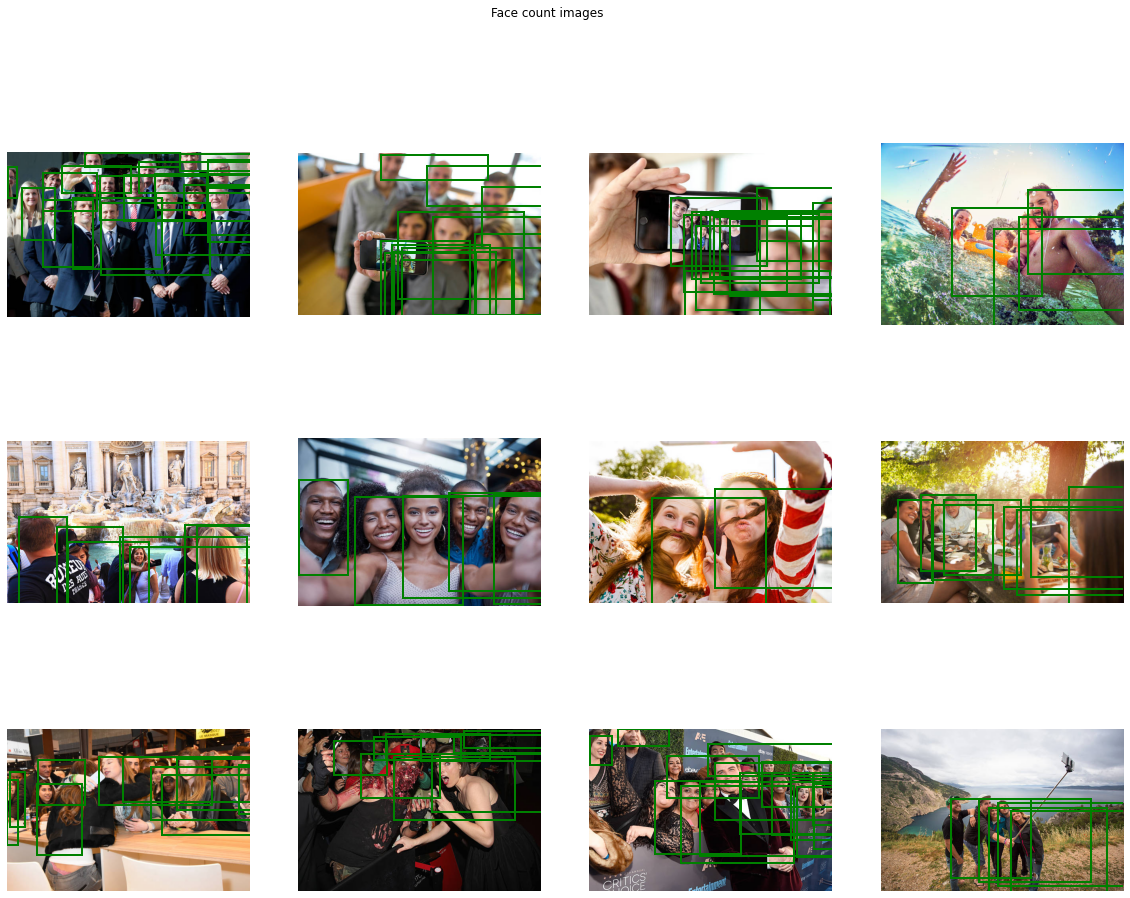

In [ ]:
plot_image_with_box(train_images)

### Important points

- Here we can see that the ```bounding boxes``` data is not only around the face but it also covers other body portion. But the __number of bounding boxes is equivalent__ to the number of __faces__ in the image. 

- Here we can see images are take into different lighting condition, and persons have different facial expression in the images. 

## Count the number of faces or bounding boxes 

        - That's what we need to predict for the test images.
        

- This data is already given but here we are creating a function for bounding box and counting the bounding box we will predict the number of faces in an Image.

In [ ]:
train

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4
...,...,...
5728,18201.jpg,2
5729,18203.jpg,3
5730,18204.jpg,5
5731,18205.jpg,8


In [ ]:
# compute the number of bounding boxes per train image
# train_images['count'] = train_images.loc[:,train_images.columns !='HeadCount'].apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)


# train_images_count = train_images.loc[:,train_images.columns !='HeadCount'].groupby('Name').sum().reset_index()

In [ ]:
# train_images_count['HeadCount']=train['HeadCount']
# train_images_count.head()

In [ ]:
# len(train_images_count.Name.unique())

Here we see the count is equivalent to the HeadCount or we can call it as ```FACECOUNT```

In [ ]:
# See this article on how to plot bar charts with Bokeh:
# https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3

def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = 'Faces in image',
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [ ]:
hist_hover(train_images, 'HeadCount', title='Number of faces per image')

Loading BokehJS ...

In [ ]:
train_images.head()

,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202


In [ ]:
df=train_images
df.head()

,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202


In [ ]:
df['x_center'] = df['xmin'] + df['width']/2
df['y_center'] = df['ymin'] + df['height']/2
df['classes'] = 0


df['image_id']=df['Name'].str.replace('.jpg','')

df = df[['image_id','xmin', 'ymin', 'width', 'height','x_center','y_center','classes']]

In [ ]:
df.head()

,image_id,xmin,ymin,width,height,x_center,y_center,classes
0,10001,192,199,612,408,498.0,403.0,0
1,10001,247,168,612,408,553.0,372.0,0
2,10001,321,176,612,408,627.0,380.0,0
3,10001,355,183,612,408,661.0,387.0,0
4,10002,339,165,612,408,645.0,369.0,0


#-------------------THANKS FOR WATCHING--------------------